# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [81]:
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [26]:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [27]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [28]:
sensor.isna().sum()
sensor.dropna(axis=1,how='any',inplace=True)

How many rows and columns are in our data?

In [31]:
sensor.shape # 1751 rows, 12 columns

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [35]:
dates_range = pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods=1751)
infer = pd.infer_freq(dates_range)
dates_range.freq = infer

In [37]:
sensor["datetime"] = pd.to_datetime(dates_range)

Assign the time series index to the dataframe's index.

In [39]:
sensor.set_index("datetime").head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
datetime,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

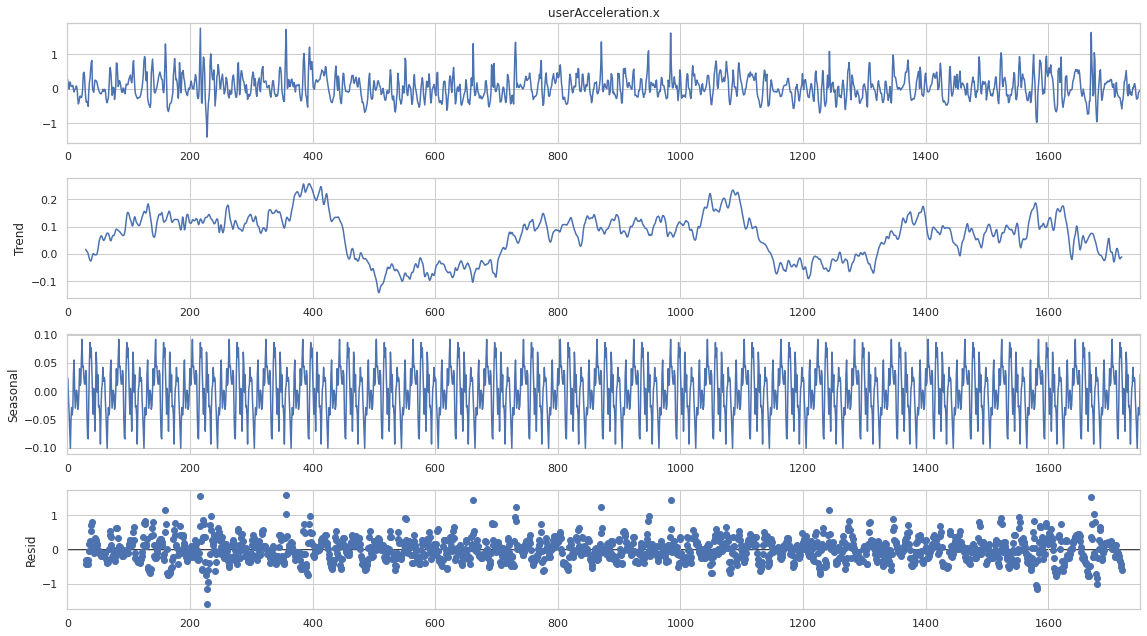

In [46]:
sensor_sd = seasonal_decompose(sensor['userAcceleration.x'], model="additive", period=60)
sensor_sd.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

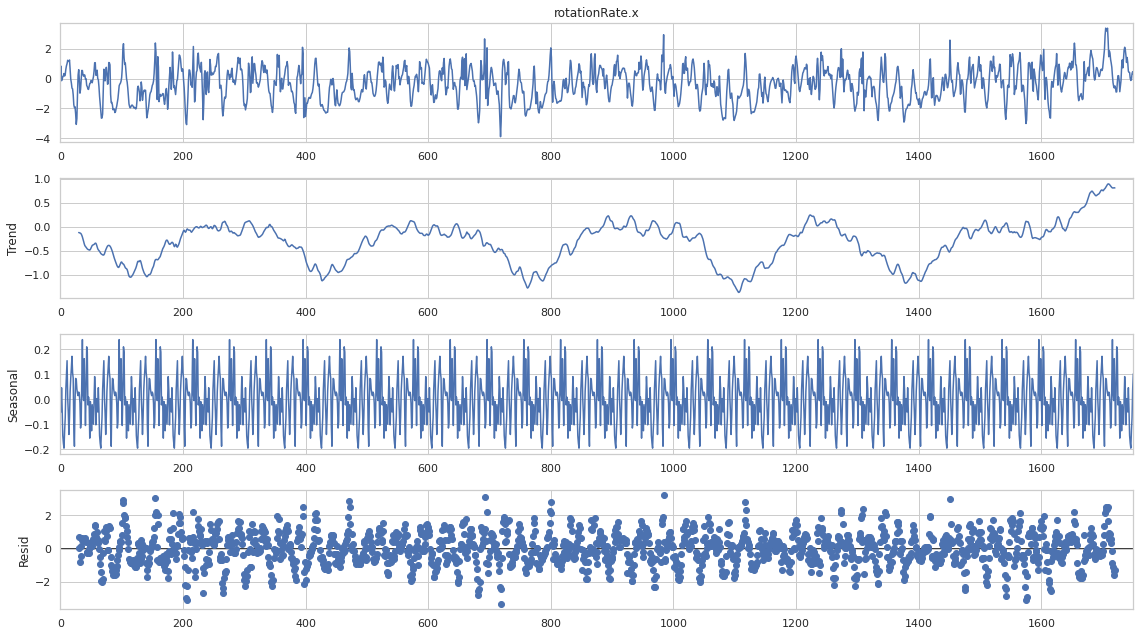

In [47]:
sensor_sd = seasonal_decompose(sensor['rotationRate.x'], model="additive", period=60)
sensor_sd.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


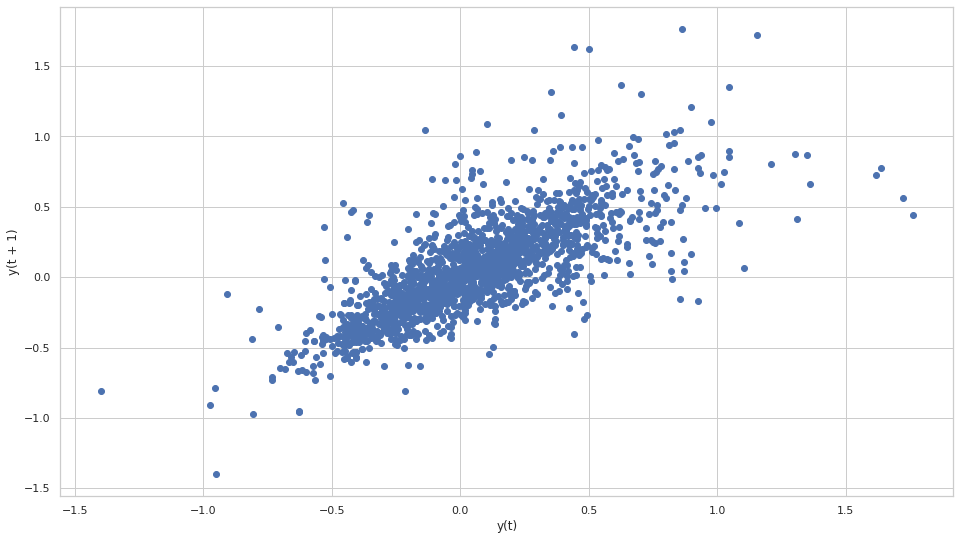

In [49]:
pd.plotting.lag_plot(sensor['userAcceleration.x']);

Create a lag plot for `rotationRate.x`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


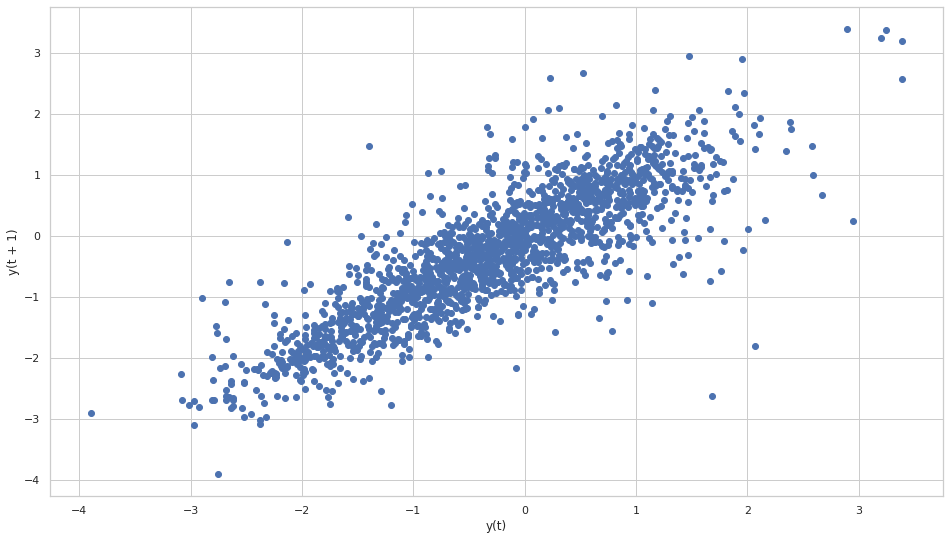

In [50]:
pd.plotting.lag_plot(sensor['rotationRate.x']);

What are your conclusions from both visualizations?

##### As the date time period is in seconds and both variables are spatial magnitudes, it makes sense having a lot of points overlaping. Any minimal change in the acceleration or in the turn ratio in this small change of time will set up two consecutive points very close. Probably the series will turn to be not stationaries.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

###### 0_H - (Null hypothesis): The series is not stationary and there is a statistically significant trend.
If the p-value> alpha (0.05), we do NOT reject the null hypothesis.
###### A_H - (Alternative hypothesis): The series is stationary.
If the p-value <alpha (0.05), we reject the null hypothesis.

In [53]:
from statsmodels.tsa.stattools import adfuller

In [66]:
adfuller(sensor['userAcceleration.x'])[1] < 0.05

True

In [67]:
adfuller(sensor['rotationRate.x'])[1] < 0.05

True

What are your conclusions from this test?

###### That we reject the null hypothesis for both variables, so both series are stationaries.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

As the ARMA model is not working, we will try working with the ARIMA model.
p: The number of lag observations included in the model, also called lag order.
q: The size of the moving average window, also called the moving average order.

In [73]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import LinearRegression

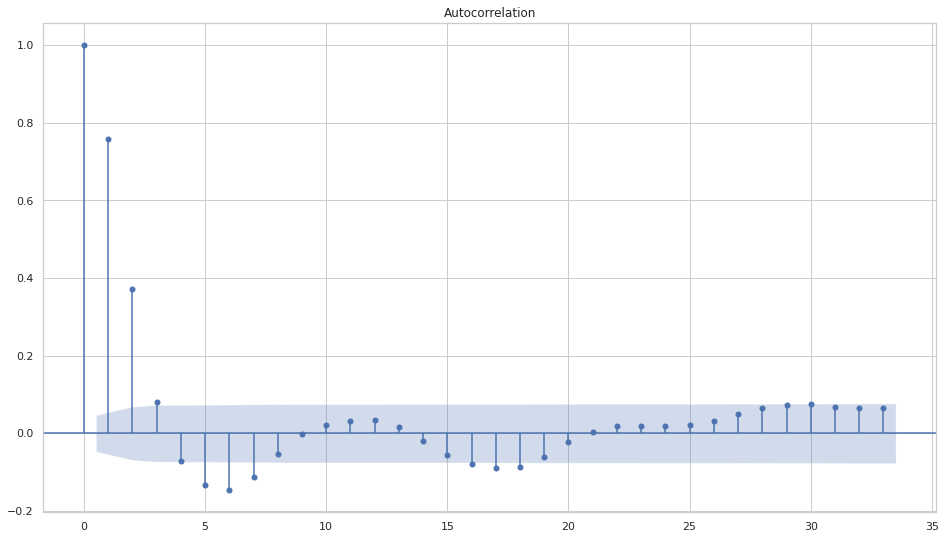

In [75]:
plot_acf(sensor['userAcceleration.x']); 
# Large spike at lag 1 followed by a damped wave that alternates between positive and negative correlations.

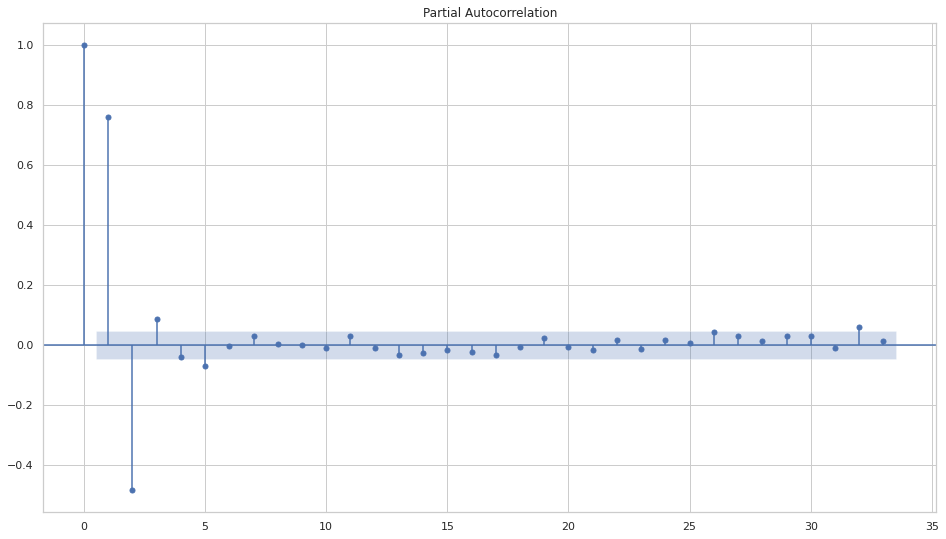

In [76]:
plot_pacf(sensor['userAcceleration.x']);
# Large spike at lag 1 that decreases after a few lags.

Therefore, how can we make sure that we choose the right order for both the AR(p) and MA(q) processes?
With the Akaike’s Information Criterion.
AIC = -2log(L) + 2k

In [78]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    results = []
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [87]:
import itertools
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

In [90]:
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=(sensor['userAcceleration.x'].tail(10)))

  0%|          | 0/64 [00:00<?, ?it/s]

In [92]:
result_df

,"(p, d, q)",AIC
0,"(7, 1, 1)",-16.666909
1,"(6, 1, 2)",-16.196977
2,"(6, 1, 0)",-15.534200
3,"(7, 1, 0)",-15.454925
4,"(4, 1, 3)",-15.030604
...,...,...
58,"(3, 1, 5)",-4.855985
59,"(3, 1, 6)",-4.389859
60,"(7, 1, 7)",-4.353790
61,"(2, 1, 7)",-3.435617


In [93]:
# The lowest AIC is for the values (7,1,1)

In [105]:
sensor2 = sensor[0:1740]

In [111]:
sensor2['userAcceleration.x'].shape

(1740,)

In [112]:
best_model = SARIMAX(sensor2['userAcceleration.x'], order=(7,1,1)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:     userAcceleration.x   No. Observations:                 1740
Model:               SARIMAX(7, 1, 1)   Log Likelihood                 375.967
Date:                Wed, 24 Nov 2021   AIC                           -733.933
Time:                        18:42:02   BIC                           -684.784
Sample:                             0   HQIC                          -715.759
                               - 1740                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1598      0.015     77.062      0.000       1.130       1.189
ar.L2         -0.5909      0.028    -20.854      0.000      -0.646      -0.535
ar.L3          0.0864      0.033      2.619      0.0

In [113]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(best_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [5.54782319e-11 1.93282298e-03 2.15569210e-03 6.41989662e-03
 1.26058801e-02 1.97220535e-02 1.99789431e-02 2.38142572e-01
 5.60358851e-01 2.07677828e+00]
p-value: [0.99999406 0.99903406 0.9999734  0.99999486 0.99999906 0.99999984
 0.99999999 0.99999238 0.9999504  0.99571711]


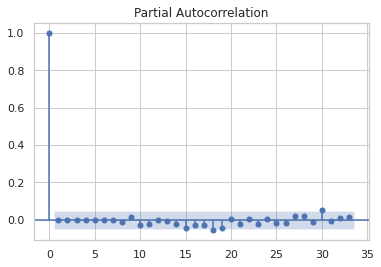

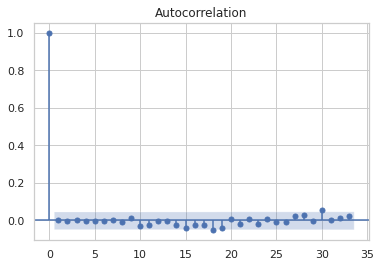

In [114]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [117]:
from statsmodels.tools.eval_measures import rmse

In [127]:
ypred = best_model.predict(sensor['userAcceleration.x'].tail())
#rmse = rmse(y, ypred)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'